<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [76]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob
import shapely.geometry as sgeom
import numpy as np
import sys
from cftime import DatetimeNoLeap
import pingouin as pg

In [100]:
def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

def lag_and_combine(ds, lags, dim="time"):
    """Creates lagged versions of the input object,
    combined along new `lag` dimension.
    NOTE: Lagging produces missing values at boundary. Use `.fillna(...)`
    to avoid problems with e.g. xr_linregress.
    Parameters
    ----------
    ds : {xr.DataArray, xr.Dataset}
        Input object
    lags : np.Array
        Lags to be computed and combined. Values denote number of timesteps.
        Negative lag indicates a shift backwards (to the left of the axis).
    dim : str
        dimension of `ds` to be lagged
    Returns
    -------
    {xr.DataArray, xr.Dataset}
        Lagged version of `ds` with additional dimension `lag`
    """

    datasets = []
    for ll in lags:
        datasets.append(ds.shift(**{dim: ll}))
    return xr.concat(datasets, dim=concat_dim_da(lags, "lag"))

def concat_dim_da(data, name):
    """creates an xarray.Dataarray to label the concat dim in xarray.concat.
    data is the dimension array and name is the name (DuHHHHH)"""
    return xr.DataArray(data, dims=[name], coords={name: (name, data)}, name=name)

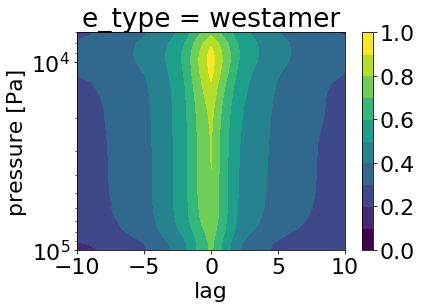

In [110]:
lags = np.arange(-10,11)#[-2,-1,0,1,2]
xr.corr(lag_and_combine(ds2, lags), 
        ds_flux.sel(e_type = ssw_type), dim ='time').plot.contourf(x = 'lag', 
                                                                   yincrease = False, 
                                                                   levels = 11,
                                                                   vmin = 0,
                                                                   vmax = 1)
plt.yscale('log')

In [18]:
infiles = glob.glob('/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_*010100-*123118.nc')
sorted(infiles)

['/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1979010100-1979123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1980010100-1980123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1981010100-1981123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1982010100-1982123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1983010100-1983123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1984010100-1984123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1985010100-1985123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1986010100-1986123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1987010100-1987123118.nc',
 '/mnt/4data/CMAM/0A.daily/ogwfluxe/ogwfluxe_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1988010

In [20]:
ds = xr.open_mfdataset(sorted(infiles), concat_dim='time', parallel=True, coords='minimal')
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 48, lon: 96, plev: 63, time: 46720)
Coordinates:
  * time       (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 8e+04 ... 0.2 0.15 0.1 0.07
  * lat        (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon        (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1460, 2), meta=np.ndarray>
    plev_bnds  (time, plev, bnds) float64 dask.array<chunksize=(1460, 63, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1460, 48, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1460, 96, 2), meta=np.ndarray>
    ogwfluxe   (time, plev, lat, lon) float32 dask.array<chunksize=(1460, 63, 48, 96), meta=np.ndarray>
Attributes:
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          CMAM30-SD
    source:                 CMAM 2013
    model_id:               CMAM
    forcing:                N/A
    parent_experiment_id:   N/A
    parent_experiment_rip:  N/A
    branch_time:            0.0
    contact:                cccma_info@ec.gc.ca
    comment:                The CMAM30 team gratefully acknowledges the Canad...
    references:             http://www.cccma.ec.gc.ca/models
    initialization_method:  1
    physics_version:        1
    tracking_id:            8a89627f-84ee-42fa-9d82-749e49a0e402
    CCCma_runid:            cmam20_abc001
    CCCma_data_licence:     1) GRANT OF LICENCE - The Government of Canada (E...
    product:                output
    experiment:             CMAM 30-year specified dynamics run
    frequency:              6hr
    creation_date:          2013-05-27T22:56:29Z
    history:                2013-05-27T22:56:29Z CMOR rewrote data to comply ...
    Conventions:            CF-1.4
    project_id:             CMAM30
    table_id:               Table 6hrPlev (10 April 2013) 303ca12ce2a31d5584f...
    title:                  CMAM model output prepared for CMAM30 CMAM 30-yea...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.2

In [46]:
e_type_ls = ['himalayas', 'westamer', 'eastasia']
temp_ls = []
for i,e_type in enumerate(e_type_ls):
    print(i,e_type)
    #ax = axes.flatten()[i]
      
    if e_type == 'himalayas':
        box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
    elif e_type == 'eastasia':
        box = sgeom.box(minx=110, maxx=145, miny=27.5, maxy=52)
    elif e_type == 'westamer':
        box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    
    box_lats = np.array(box.bounds)[1::2]
    box_lons = np.array(box.bounds)[::2]
    box_lons[box_lons < 0] += 360
        
    sel_dict = dict(lat = slice(box_lats[0], box_lats[1]), \
                    lon = slice(box_lons[0], box_lons[1]), \
                    plev = slice(None,7000))
    print(sel_dict)
    temp = ds['ogwfluxe'].sel(**sel_dict).mean(['lat','lon']).resample(time = '1D').mean('time').load()
    temp_ls.append(temp)
    #sys.exit()

0 himalayas
{'lat': slice(20.0, 42.0, None), 'lon': slice(70.0, 105.0, None), 'plev': slice(None, 7000, None)}
1 westamer
{'lat': slice(27.5, 52.0, None), 'lon': slice(235.0, 257.5, None), 'plev': slice(None, 7000, None)}
2 eastasia
{'lat': slice(27.5, 52.0, None), 'lon': slice(110.0, 145.0, None), 'plev': slice(None, 7000, None)}


In [55]:
ds_flux = xr.concat(temp_ls, dim = 'e_type')
ds_flux['e_type'] = e_type_ls

plt.rcParams.update({'font.size': 22})

(100000.0, 7000)

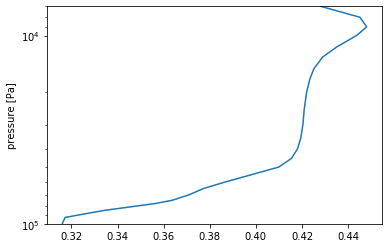

In [45]:
xr.corr(ds2,temp, dim ='time').plot(y = 'plev')
plt.yscale('log')
plt.ylim(1e5,7000)

In [97]:
ds2[mask]

<xarray.DataArray 'oGWD' (time: 2880)>
array([-1.06237763, -1.03054494, -1.48312752, ..., -4.85538916,
       -4.9144879 , -5.97963563])
Coordinates:
  * time     (time) object 1979-01-01 00:00:00 ... 2010-12-31 00:00:00

himalayas (37, 1)
eastasia (37, 1)
westamer (25, 1)


(0.25, 1)

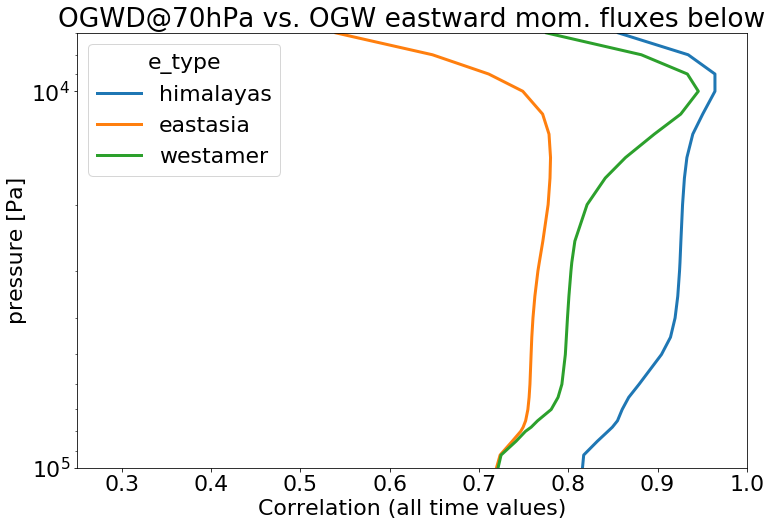

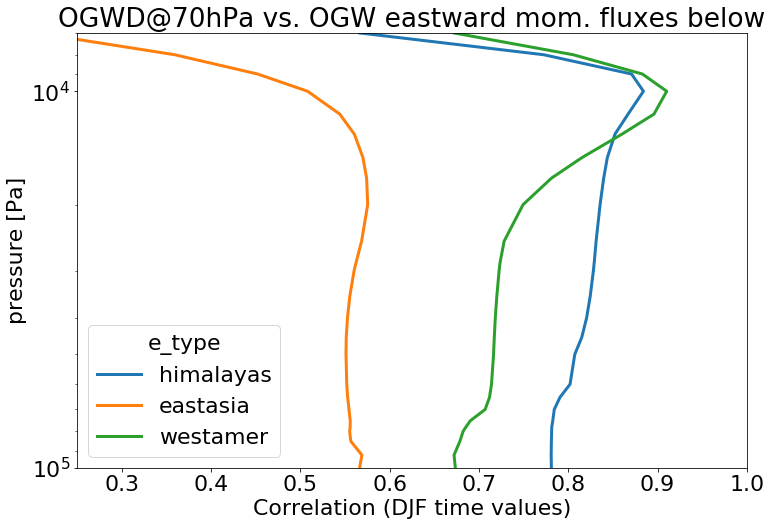

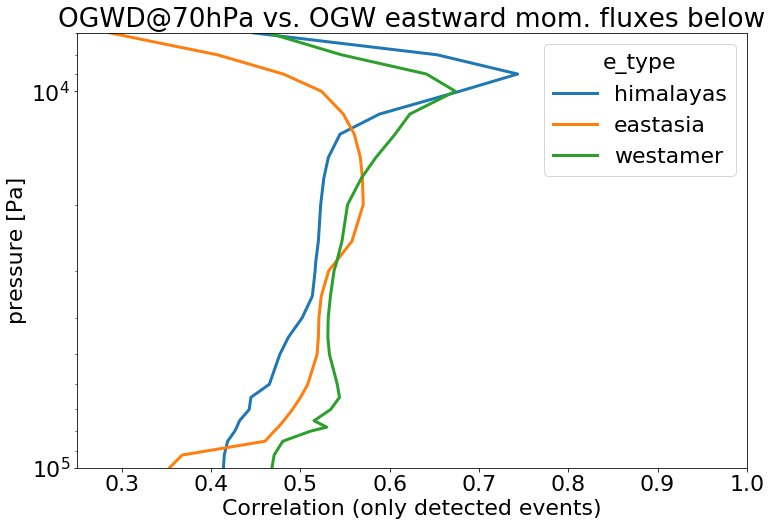

In [164]:
ssw_type_ls = ['himalayas', 'eastasia', 'westamer']
ch_lev = 70
timescale = 20

corr_ls = []
corr_w_ls = []
ri_ls = []
corr_d_ls = []
for ssw_type in ssw_type_ls:
    file_path = '../notebooks/accelogw_{}_hotspot@{}hPa_ts.csv'.format(ssw_type, ch_lev)
    df_dates_orig = pd.read_csv(file_path, index_col=0, parse_dates=True)
    ds2 = df_dates_orig['oGWD'].to_xarray()
    ds2['time'] = temp.time
    
    corr_ls.append(xr.corr(ds2, ds_flux.sel(e_type = ssw_type), dim ='time'))
    
    m_index = ds2.time.dt.month
    mask = (m_index == 12) | (m_index == 1) | (m_index == 2)
    corr_w_ls.append(xr.corr(ds2[mask], ds_flux.sel(e_type = ssw_type)[mask], dim ='time'))
    y = ds2[mask].to_dataframe().reset_index()['oGWD']
    df = ds_flux.sel(e_type = ssw_type, plev = [10000,50000,85000])[mask].to_dataframe().reset_index()#[['plev','ogwfluxe']]
    X = df.pivot(index = 'time', columns = 'plev', values = 'ogwfluxe').reset_index(drop=True)

    lm = pg.linear_regression(X, y, relimp=True)
    ri = lm[['names', 'relimp']].set_index('names')
    ri.columns = [ f'{ssw_type}'] #ri.rename({'relimp': f'{ssw_type}'})
    ri_ls.append(ri)#.plot.bar()
    #plt.title(f'{ssw_type}')
    #plt.ylim(0,0.5)

    df_dates_orig = open_date_file('../notebooks/accelogw_{}_hotspot@{}hPa_{}dayts_indexes.csv'.format(ssw_type, ch_lev, timescale))
    df_dates = df_dates_orig.set_index('BeginDate')
    m_index = df_dates.index.month
    mask = (m_index == 12) | (m_index == 1) | (m_index == 2)
    df_dates = df_dates[mask]

    
    print(ssw_type, df_dates.shape)
    obj = pd.to_datetime(df_dates.index)
    dates = [
    DatetimeNoLeap(year, month, day) 
    for year, month, day in  zip(obj.year,obj.month, obj.day)
                                 ]
    
    corr_d_ls.append(xr.corr(ds2.sel(time = dates), 
                           ds_flux.sel(e_type = ssw_type,
                                       time = dates), dim ='time'))

    
    
corr_all = xr.concat(corr_ls, dim = 'e_type')
corr_all['e_type'] = ssw_type_ls
corr_all.plot(y = 'plev', lw =3, size = 8, hue ='e_type')
plt.yscale('log')
plt.ylim(1e5,7000)
plt.xlim(0.25,1)
plt.title(f'OGWD@70hPa vs. OGW eastward mom. fluxes below')
plt.xlabel('Correlation (all time values)')

corr_all = xr.concat(corr_w_ls, dim = 'e_type')
corr_all['e_type'] = ssw_type_ls
corr_all.plot(y = 'plev', lw =3, size = 8, hue ='e_type')
plt.yscale('log')
plt.ylim(1e5,7000)
plt.xlim(0.25,1)
plt.title(f'OGWD@70hPa vs. OGW eastward mom. fluxes below')
plt.xlabel('Correlation (DJF time values)')

corr_all = xr.concat(corr_d_ls, dim = 'e_type')
corr_all['e_type'] = ssw_type_ls
p = corr_all.plot(y = 'plev', lw =3, size = 8, hue ='e_type')
plt.yscale('log')
plt.ylim(1e5,7000)
plt.title(f'OGWD@70hPa vs. OGW eastward mom. fluxes below')
plt.xlabel('Correlation (only detected events)')
plt.xlim(0.25,1)

Text(0.5, 0, 'pressure levels [Pa]')

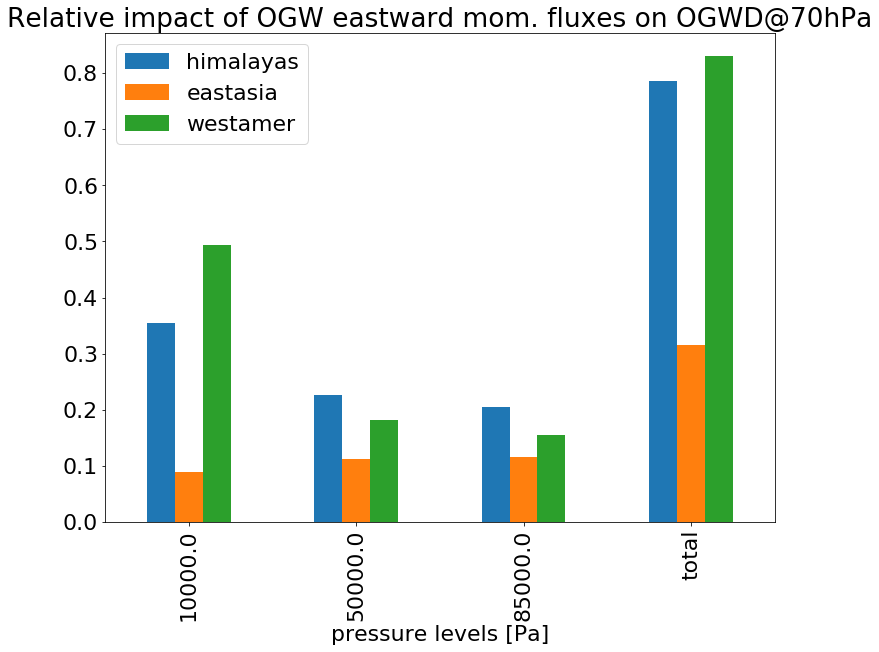

In [207]:
ri_all = pd.concat(ri_ls, axis = 1).iloc[1:]#[ssw_type_ls]
ri_all = pd.concat([ri_all, ri_all.sum(axis = 0).to_frame('total').T])
ri_all.plot.bar(figsize = (12,9))
plt.title('Relative impact of OGW eastward mom. fluxes on OGWD@70hPa')
plt.xlabel('pressure levels [Pa]')